# Homework 2 - balancing & binning (deadline 27. 11. 2022, 23:59)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Properly comment all your steps. Comments are evaluated for 2 points of the total together with the final presentation of the solution. However, it is not desirable to write novels! 
* Do not leave the task to the last minute.
* Hand in a notebook that has already been run (i.e. do not delete outputs before handing in).

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance. _(3 points)_
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.** _(6 points)_
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results and discuss (give a comment). _(5 points)_
  
All your steps and following code **have to be commented!** Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 16 points.**

## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error, confusion_matrix, accuracy_score, f1_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE

from sklearn.preprocessing import KBinsDiscretizer

import itertools
from collections import Counter

%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [2]:
RANDOM_STATE = 333

In [3]:
df = pd.read_csv("data.csv")

# Data info

In [4]:
# ukazka datasetu
df.head(10)

y  xind_01  xind_02_cat  xind_03  xind_04_cat  xind_05_cat  xind_06_bin  \
0  0        2            1        5            1            6            0   
1  0        2            1        6            0            0            0   
2  0        2            1        9            0            0            1   
3  0        1            1        6            0            0            1   
4  0        1            1        5            1            0            0   
5  0        1            1        2            1            0            0   
6  0        2            1        3            0            0            0   
7  0        2            1        3            1            0            0   
8  0        0            2        1            0            0            1   
9  0        5            1        2            1            0            0   

   xind_07_bin  xind_08_bin  xind_09_bin  xind_10_bin  xind_11_bin  \
0            1            0            0            0            0   
1            0            0            1            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            1            0            0            0            0   
5            1            0            0            0            0   
6            0            0            1            0            0   
7            1            0            0            0            0   
8            0            0            0            0            0   
9            1            0            0            0            0   

   xind_12_bin  xind_13_bin  xind_14  xind_15  xind_16_bin  xind_17_bin  \
0            0            0        0       10            1            0   
1            0            0        0       10            1            0   
2            0            0        0       12            1            0   
3            0            0        0       10            1            0   
4            0            0        0        6            1            0   
5            0            0        0        6            1            0   
6            0            0        0       11            0            1   
7            1            0        1        0            0            0   
8            1            0        1        5            1            0   
9            0            0        0       10            0            0   

   xind_18_bin  xreg_01  xreg_02   xreg_03  xcar_01_cat  xcar_02_cat  \
0            0      0.6      0.0  0.602599            7            1   
1            0      0.4      0.0  0.511126            6            1   
2            0      0.1      0.1 -1.000000            7            1   
3            0      0.8      0.1  0.463006            7            1   
4            0      0.4      0.0  0.685109           10            1   
5            0      0.7      0.3  0.619476           11            0   
6            0      0.9      0.5  1.207528           11            0   
7            1      0.4      0.0  0.522614           11            0   
8            0      0.9      1.1  0.602599            7            1   
9            0      0.9      0.3  0.652399           11            1   

   xcar_03_cat  xcar_04_cat  xcar_05_cat  xcar_06_cat  xcar_07_cat  \
0            0            0            1            1            1   
1           -1            0            1            0            1   
2            1            0            0           14            1   
3           -1            0           -1           11            1   
4           -1            0           -1            7            1   
5           -1            0           -1           10            1   
6            0            9            0           17            1   
7            1            9            0           15            1   
8            1            2            0            1            1   
9            1            1            0           12 

In [5]:
df.describe()

y        xind_01    xind_02_cat        xind_03  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.036448       1.900378       1.358943       4.423318   
std         0.187401       1.983789       0.664594       2.699902   
min         0.000000       0.000000      -1.000000       0.000000   
25%         0.000000       0.000000       1.000000       2.000000   
50%         0.000000       1.000000       1.000000       4.000000   
75%         0.000000       3.000000       2.000000       6.000000   
max         1.000000       7.000000       4.000000      11.000000   

         xind_04_cat    xind_05_cat    xind_06_bin    xind_07_bin  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.416794       0.405188       0.393742       0.257033   
std         0.493311       1.350642       0.488579       0.436998   
min        -1.000000      -1.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       0.000000       1.000000       1.000000   
max         1.000000       6.000000       1.000000       1.000000   

         xind_08_bin    xind_09_bin    xind_10_bin    xind_11_bin  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.163921       0.185304       0.000373       0.001692   
std         0.370205       0.388544       0.019309       0.041097   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         xind_12_bin    xind_13_bin        xind_14        xind_15  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.009439       0.000948       0.012451       7.299922   
std         0.096693       0.030768       0.127545       3.546042   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       5.000000   
50%         0.000000       0.000000       0.000000       7.000000   
75%         0.000000       0.000000       0.000000      10.000000   
max         1.000000       1.000000       4.000000      13.000000   

         xind_16_bin    xind_17_bin    xind_18_bin        xreg_01  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.660823       0.121081       0.153446       0.610991   
std         0.473430       0.326222       0.360417       0.287643   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.400000   
50%         1.000000       0.000000       0.000000       0.700000   
75%         1.000000       0.000000       0.000000       0.900000   
max         1.000000       1.000000       1.000000       0.900000   

             xreg_02        xreg_03    xcar_01_cat    xcar_02_cat  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.439184       0.551102       8.295933       0.829931   
std         0.404264       0.793506       2.508270       0.375716   
min         0.000000      -1.000000      -1.000000      -1.000000   
25%         0.200000       0.525000       7.000000       1.000000   
50%         0.300000       0.720677       7.000000       1.000000   
75%         0.600000       1.000000      11.000000       1.000000   
max         1.800000       4.037945      11.000000       1.000000   

         xcar_03_cat    xcar_04_cat    xcar_05_cat    xcar_06_cat  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean       -0.504899       0.725192      -0.157732       6.555340   
std         0.788654       2.153463       0.844417       5.501445   
min        

In [6]:
# je videt, ze target promenna je velmi nevyvazena
df['y'].value_counts()

0    573518
1     21694
Name: y, dtype: int64

# Rozdělení dat

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'), df.y, test_size=0.3,
#                                                    random_state=RANDOM_STATE, stratify=df['y'], shuffle=True)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,
#                                                    random_state=RANDOM_STATE, stratify=y_train, shuffle=True)

In [8]:
#df_train = pd.concat([X_train, y_train], axis=1)
#df_train.to_csv('train.csv', index=True)

#df_val = pd.concat([X_val, y_val], axis=1)
#df_val.to_csv('val.csv', index=True)

#df_test = pd.concat([X_test, y_test], axis=1)
#df_test.to_csv('test.csv', index=True)

In [9]:
# nacteni trenovaci mnoziny
df_train = pd.read_csv("train.csv", index_col=0)

X_train = df_train.drop(columns=['y'])
y_train = df_train.y
X_train.shape

(312486, 57)

In [10]:
# nacteni validacni mnoziny
df_val = pd.read_csv("val.csv", index_col=0)

X_val = df_val.drop(columns=['y'])
y_val = df_val.y
X_val.shape

(104162, 57)

In [11]:
# nacteni testovaci
df_test = pd.read_csv("test.csv", index_col=0)

X_test = df_test.drop(columns=['y'])
y_test = df_test.y
X_test.shape

(178564, 57)

# Rozdělení příznaků

Příznaky se dělí na kategorické, zakončené na "cat", binární, zakončené na "bin" a ostatní. Roztřídila jsem jednotlivé příznaky podle kategorie, do které náleží. Na vybrané příznaky ze skupiny "other" jsem v další sekci aplikovala binning.

In [12]:
categorical_f = set(df_train.columns[df_train.columns.str.endswith('cat')])
binary_f = set(df_train.columns[df_train.columns.str.endswith('bin')])
other_f = set(df_train.columns) - set(binary_f).union(set(categorical_f), {'y'})

In [13]:
categorical_f

{'xcar_01_cat',
 'xcar_02_cat',
 'xcar_03_cat',
 'xcar_04_cat',
 'xcar_05_cat',
 'xcar_06_cat',
 'xcar_07_cat',
 'xcar_08_cat',
 'xcar_09_cat',
 'xcar_10_cat',
 'xcar_11_cat',
 'xind_02_cat',
 'xind_04_cat',
 'xind_05_cat'}

In [14]:
binary_f

{'xcalc_15_bin',
 'xcalc_16_bin',
 'xcalc_17_bin',
 'xcalc_18_bin',
 'xcalc_19_bin',
 'xcalc_20_bin',
 'xind_06_bin',
 'xind_07_bin',
 'xind_08_bin',
 'xind_09_bin',
 'xind_10_bin',
 'xind_11_bin',
 'xind_12_bin',
 'xind_13_bin',
 'xind_16_bin',
 'xind_17_bin',
 'xind_18_bin'}

In [15]:
other_f

{'xcalc_01',
 'xcalc_02',
 'xcalc_03',
 'xcalc_04',
 'xcalc_05',
 'xcalc_06',
 'xcalc_07',
 'xcalc_08',
 'xcalc_09',
 'xcalc_10',
 'xcalc_11',
 'xcalc_12',
 'xcalc_13',
 'xcalc_14',
 'xcar_11',
 'xcar_12',
 'xcar_13',
 'xcar_14',
 'xcar_15',
 'xind_01',
 'xind_03',
 'xind_14',
 'xind_15',
 'xreg_01',
 'xreg_02',
 'xreg_03'}

# Pomocné funkce

In [16]:
# funkce vykreslujici matici zamen

# kod prevzat z http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
# vykresli matici zamen a matici zamen se znormalizovanymi hodnotami
# kod prevzat ze 4. cviceni PDD

def print_conf_matrix(yt, yp):
    cnf_matrix = confusion_matrix(yt, yp)
    
    np.set_printoptions(precision=2)
    class_names = [0,1]

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

In [18]:
# funkce, ktera provede natrenovani modelu a jeho vyhodnoceni na zadanych datech
# vraci patricnou hodnotu accuracy a f1 score

def evaluate(Xt_train, yt_train, Xt_test, yt_test, model, conf_mat=False):
    
    dt = model(random_state=RANDOM_STATE)
    dt.fit(Xt_train, yt_train)
    
    yp_test = dt.predict(Xt_test)
    
    acc = metrics.accuracy_score(yt_test, yp_test)
    f1 = metrics.f1_score(yt_test, yp_test)
    
    if conf_mat:
        print_conf_matrix(yt_test, yp_test)
    
    return  acc, f1

# Prvotní klasifikace
Jako klasifikátor jsem si zvolila model rozhodovacího stromu. Z výsledků predikce modelu natrénovaného na trénovací sadě dat a vyhodnoceného na validační sadě dat je vidět, že model je kvůli nevyváženosti target třídy přeučený a predikuje téměř vždy hodnotu targetu 0. Ze znormalizované matice záměn je vidět, že správně model predikuje hodnotu 1 pouze ve 5 % případů.

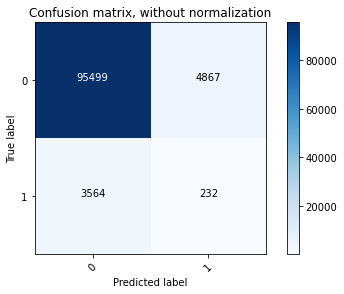

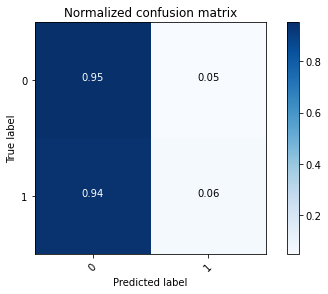

accuracy 0.9190587738330677
f1 score 0.052164137155705455


In [19]:
acc, f1 = evaluate(X_train, y_train, X_val, y_val, DecisionTreeClassifier, conf_mat=True)

print(f'accuracy {acc}')
print(f'f1 score {f1}')

# Binning

Příznaky na, kterých jsem aplikovala binning, jsem vybírala z numerických nekategorických příznaků. Zvolila jsem 2 binning přístupy: dělení na bloky stejné šířky a dělení na bloky stejné výšky. Pro každý z přístupů jsem nejprve vyzkoušela různé počty bins pro jednotlivé vybrané sloupce. A to tak, že jsem na upravených trénovacích sadách dat natrénovala Rozhodovací strom a jeho přesnost jsem měřila pomocí F1 skóre na validační sadě dat.


Vhodné příznaky pro jednotlivé binning přístupy jsem vybrala na základě průzkumu rozložení hodnot jednotlivých příznaků. To zobrazují následující histogramy:

array([[<AxesSubplot:title={'center':'xcalc_04'}>,
        <AxesSubplot:title={'center':'xreg_03'}>,
        <AxesSubplot:title={'center':'xcalc_13'}>,
        <AxesSubplot:title={'center':'xcalc_14'}>,
        <AxesSubplot:title={'center':'xcar_15'}>],
       [<AxesSubplot:title={'center':'xcalc_06'}>,
        <AxesSubplot:title={'center':'xcalc_08'}>,
        <AxesSubplot:title={'center':'xcalc_02'}>,
        <AxesSubplot:title={'center':'xreg_02'}>,
        <AxesSubplot:title={'center':'xcar_12'}>],
       [<AxesSubplot:title={'center':'xreg_01'}>,
        <AxesSubplot:title={'center':'xcar_14'}>,
        <AxesSubplot:title={'center':'xcalc_10'}>,
        <AxesSubplot:title={'center':'xind_15'}>,
        <AxesSubplot:title={'center':'xind_14'}>],
       [<AxesSubplot:title={'center':'xcalc_09'}>,
        <AxesSubplot:title={'center':'xcalc_03'}>,
        <AxesSubplot:title={'center':'xcalc_11'}>,
        <AxesSubplot:title={'center':'xcar_13'}>,
        <AxesSubplot:title={'center':

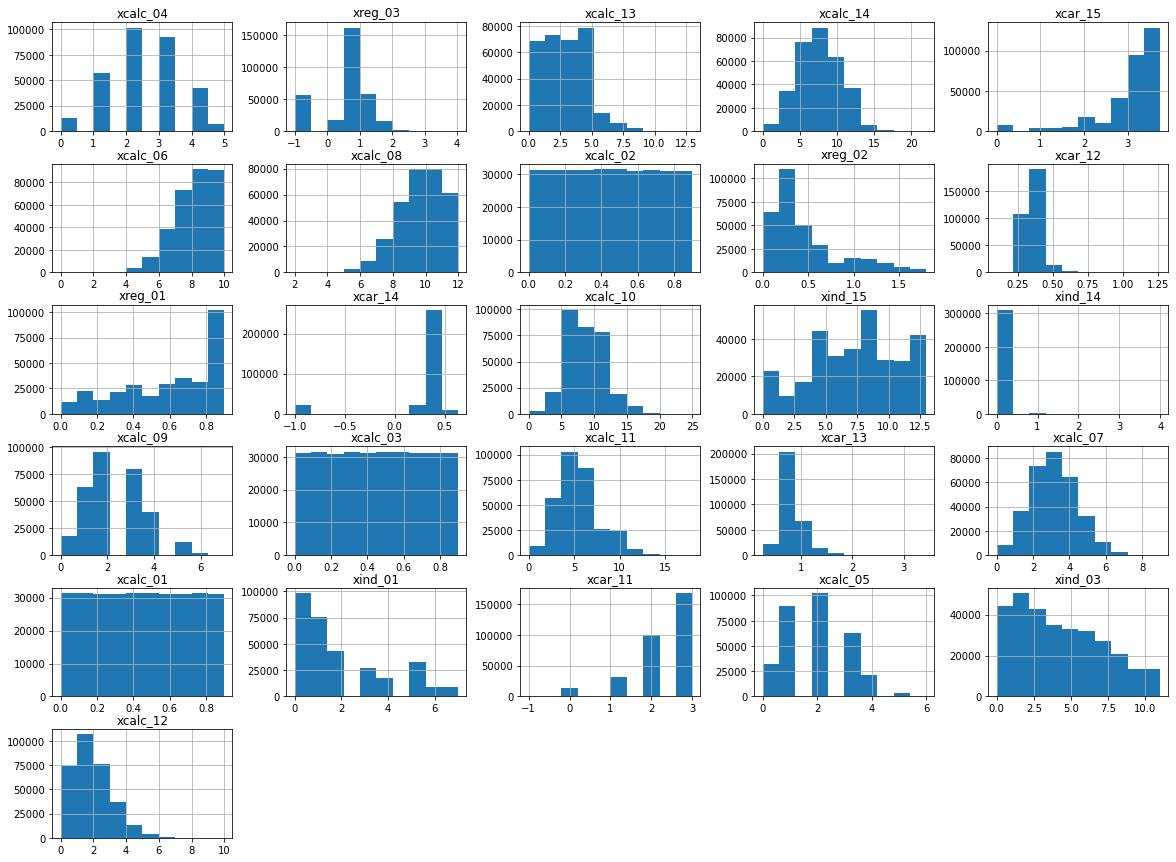

In [20]:
# ukazka rozlozeni vsech priznaku
plt.rcParams["figure.figsize"] = (20,15)
X_train[list(other_f)].hist()

Vybrané příznaky pro dělení na bloky stejné šířky jsem vybrala příznaky: 'xcalc_03', 'xcalc_01', 'xcalc_02'. Jejich rozložení odpovídá téměř rovnoměrnému rozložení z toho důvodu jsou tyto příznaky pro dělení podle šířky ideální.

Jako příznaky na dělení podle výšky jsem vybrala tyto tři příznaky: 'xcalc_13', 'xind_03', 'xind_15'. Jelikož se jedná o příznaky, jejichž rozdělení není podobné rovnoměrnému rozložení použití dělení podle šířky by pro ně bylo nevhodné.

In [21]:
# priznaky pro deleni podle vysky
f_quantile = ['xcalc_13', 'xind_03', 'xind_15']
# priznaky pro deleni podle sirky
f_uniform = ['xcalc_03', 'xcalc_01', 'xcalc_02']

array([[<AxesSubplot:title={'center':'xcalc_13'}>,
        <AxesSubplot:title={'center':'xind_03'}>],
       [<AxesSubplot:title={'center':'xind_15'}>, <AxesSubplot:>]],
      dtype=object)

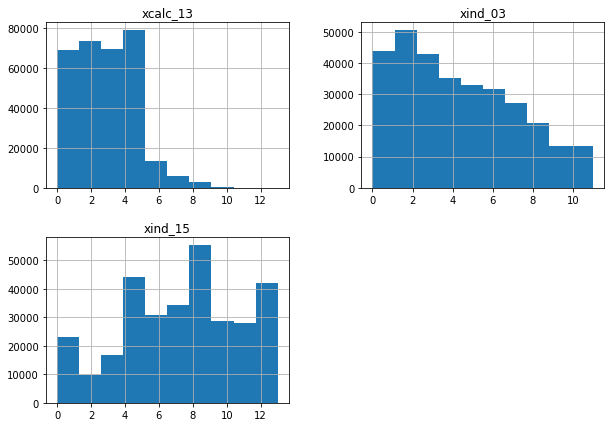

In [22]:
# rozlozeni priznaku pro deleni podle vysky
plt.rcParams["figure.figsize"] = (10,7)
X_train[f_quantile].hist()

array([[<AxesSubplot:title={'center':'xcalc_03'}>,
        <AxesSubplot:title={'center':'xcalc_01'}>],
       [<AxesSubplot:title={'center':'xcalc_02'}>, <AxesSubplot:>]],
      dtype=object)

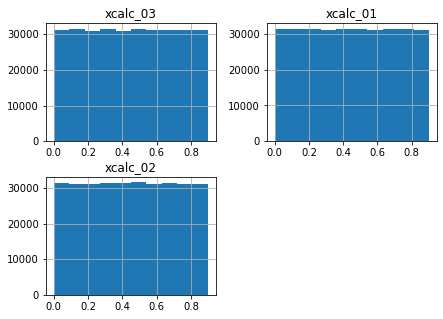

In [23]:
# rozdeleni priznaku pro deleni podle sirky
plt.rcParams["figure.figsize"] = (7,5)
X_train[f_uniform].hist()

In [24]:
# funkce, ktera provede binning, vybranou metodou, na zadanych priznacich
# pro kazdy priznak najde nejlepsi pocet bins v zadanem rozsahu
# vraci tabulky s vysledky pro kazdy sloupec (nej bins, acc, f1) a df se zbinovanymi sloupci

def get_binning(cols, method, min_bins, max_bins, X_train, y_train, X_test, y_test):
    results = pd.DataFrame(columns=['col', 'bins', 'acc', 'f1'])
    
    df_binned = pd.DataFrame(columns=[cols])
    
    for col in cols:
        results.loc[len(results.index)] = [col, min_bins, 0, 0] 
        df_binned[col] = X_train[col]
        
        for k in range(min_bins, max_bins+1):
            Xb = X_train.drop(columns=[col])
            
            if method == 'width':
                Xb[col] = pd.cut(X_train[col], bins = k, labels = False, include_lowest=True)
                
            elif method == 'height':
                 Xb[col], bins = pd.qcut(X_train[col], q = k, retbins = True, labels = False, duplicates='drop')
                    
            
            
            acc, f1 = evaluate(Xb, y_train, X_test, y_test, DecisionTreeClassifier)
            acc, f1 = round(acc*100, 3), round(f1*100, 3)
            
            if f1 > results[results['col'] == col]['f1'].iloc[0]:
                results.loc[results[results['col'] == col].index] = [col, k, acc, f1]
                df_binned[col] = Xb[col] 
                
    return results, df_binned

## Stejná výška
Po diskretizaci vybraných příznaků podle výšky, se ukázal jako nejlepší počet bins pro jednotlivé vybrané příznaky:
* xcalc_13 - 4 bins
* xind_03 - 5 bins
* xind_15 - 11 bins


U všech příznaků došlo po binningu ke drobnému zlepšení naměřeného F1 skóre na validační sadě dat. Nejvyššího zlepšení dosáhl příznak xind_03.

In [25]:
results_quantile, df_binned_quantile = get_binning(f_quantile, 'height', 3, 15, X_train, y_train, X_val, y_val)

In [26]:
# vysledky
print(results_quantile)

# ukazka sloupcu po aplikaci binningu
display(df_binned_quantile.head())

        col  bins     acc     f1
0  xcalc_13     4  90.222  5.511
1   xind_03     5  18.649  6.863
2   xind_15    11  19.770  6.840


xcalc_13 xind_03 xind_15
330657        3       2       3
594500        2       0       4
316759        0       0       1
392604        2       0       5
500306        0       3       7

## Stejná šířka
Po diskretizaci vybraných příznaků podle šířky se ukázal jako nejlepší počet bins pro jednotlivé vybrané příznaky:
* xcalc_03 - 9 bins
* xcalc_01 - 6 bins
* xcalc_02 - 4 bins


U všech příznaků došlo opět po binningu ke drobnému zlepšení naměřeného F1 skóre predikce na validační sadě dat. Nejvyššího zlepšení dosáhl příznak xcalc_01.

In [27]:
results_uniform, df_binned_uniform = get_binning(f_uniform, 'width', 3, 15, X_train, y_train, X_val, y_val)

In [28]:
# vysledky
print(results_uniform)

# ukazka sloupcu po aplikaci binningu
display(df_binned_uniform.head())

        col  bins     acc     f1
0  xcalc_03     9  69.154  7.294
1  xcalc_01     6  69.998  7.457
2  xcalc_02     4  71.517  7.438


xcalc_03 xcalc_01 xcalc_02
330657        3        5        3
594500        1        0        1
316759        1        4        3
392604        2        0        0
500306        0        4        0

## Otestování nejlepších počtu binů na testovací množině
Následně jsem provedla ještě otestování výsledků různých druhů binningu na testovací sadě dat. Výsledky jednotlivých binning metod jsem srovnávala mezi sebou a s výsledky predikátoru natrénovaného na originálním trénovacím datasetu a testovaného na testovací sadě dat.


Otestovala jsem tři případy:
1. je proveden binning podle výšky na vybraných příznacích ('xcalc_13', 'xind_03', 'xind_15'), pro každý příznak je použit počet ideální binů, který vyšel na validační sadě dat.
2. je proveden binning podle šířky na vybraných příznacích ('xcalc_03', 'xcalc_01', 'xcalc_02'), pro každý příznak je použit počet ideální binů, který vyšel na validační sadě dat.
3. je proveden binning podle výšky i šířky


Nejlepších výsledků bylo dasaženo v 2. případě, tedy dělení podle šířky. Výsledky jednotlivých binning přístupů zobrazuje tabulka níže.

In [29]:
results_final = pd.DataFrame(columns=['method', 'acc', 'f1'])

In [30]:
# testovani na testovaci sade bez binningu
acc_o, f1_o = evaluate(X_train, y_train, X_test, y_test, DecisionTreeClassifier)
results_final.loc[len(results_final.index)] = ['origin', acc_o, f1_o] 

# testovani na testovaci sade za pouziti binningu podle vysky pro vybrane priznaky
X_quantile = X_train.drop(columns=f_quantile)
X_quantile[f_quantile] = df_binned_quantile[f_quantile]
acc_q, f1_q = evaluate(X_quantile, y_train, X_test, y_test, DecisionTreeClassifier)
results_final.loc[len(results_final.index)] = ['height', acc_q, f1_q] 


# testovani na testovaci sade za pouziti binningu podle sirky pro vybrane priznaky
X_uniform = X_train.drop(columns=f_uniform)
X_uniform[f_uniform] = df_binned_uniform[f_uniform]
acc_u, f1_u = evaluate(X_uniform, y_train, X_test, y_test, DecisionTreeClassifier)
results_final.loc[len(results_final.index)] = ['width', acc_u, f1_u] 

# testovani na testovaci sade za pouziti binningu podle sirky a vysky pro vybrane priznaky
X_quantile_uniform = X_train.drop(columns=f_quantile)
X_quantile_uniform = X_train.drop(columns=f_uniform)
X_quantile_uniform[f_quantile] = df_binned_quantile[f_quantile]
X_quantile_uniform[f_uniform] = df_binned_uniform[f_uniform]
acc_all, f1_all = evaluate(X_quantile_uniform, y_train, X_test, y_test, DecisionTreeClassifier)
results_final.loc[len(results_final.index)] = ['height+width', acc_all, f1_all] 

In [31]:
# prevod na procenta
results_final.acc = results_final.acc*100
results_final.f1 = results_final.f1*100
results_final = results_final.round({'acc': 3, 'f1': 3})

In [32]:
# tabulka s vysledky
results_final

method     acc     f1
0        origin  91.872  5.385
1        height  32.010  7.161
2         width  74.196  7.153
3  height+width  68.997  6.650

# Balancing data

Pro data balancing jsem zvolila dva hlavní přístupy: Under-sampling a Over-sampling, Pro každý z přístupů jsem vybrala na základě rešerše několik data balancing metod z knihovny imbalanced-learn, jejichž přínos pro predikci jsem ověřovala metrikou F1 score na výsledcích predikce rozhodovacím stromem.  


Zdroj využitých obrázků: 
https://imbalanced-learn.org/stable/over_sampling.html
https://imbalanced-learn.org/stable/under_sampling.html

In [33]:
# fce pro ziskani vysledku, pripadne vypsani confusion matrix
def get_results(Xt_train, yt_train, Xt_test, yt_test, method, model, results_df, 
                conf_mat=True, print_res=True):
    
    # vypocet metrik
    acc, f1 = evaluate(Xt_train, yt_train, Xt_test, yt_test, model, conf_mat)
    
    # vypsani vysledku
    if print_res:
        print(f'Metoda: {method}')
        print(f'accuracy {round(acc*100, 3)} %')
        print(f'f1 score {round(f1*100, 3)} %')
    
    # ulozeni vysledky do df results
    if method in set(results_df['method']):
        results_df.loc[results[results['method'] == method].index] = [method, round(acc*100, 3), round(f1*100, 3)]
    else:
        results_df.loc[len(results_df.index)] = [method, round(acc*100, 3), round(f1*100, 3)]

In [34]:
# df pro ukladani vysledku
results = pd.DataFrame(columns=['method', 'acc', 'f1'])

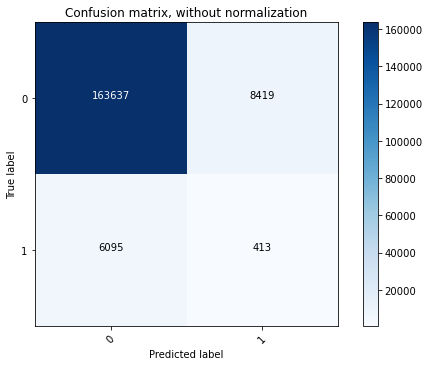

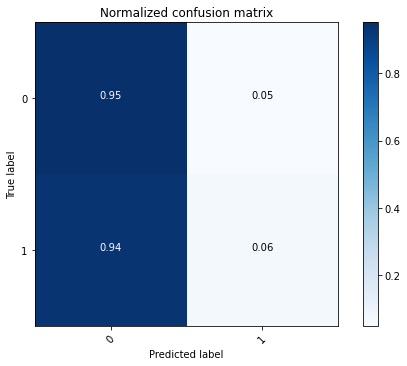

Metoda: origin
accuracy 91.872 %
f1 score 5.385 %


In [35]:
# vysledky pred vyvazovanim dat
get_results(X_train, y_train, X_test, y_test, 'origin', DecisionTreeClassifier, results,
                conf_mat=True, print_res=True)

In [36]:
# pocatecni stav df s vysledky
results

method     acc     f1
0  origin  91.872  5.385

# Under-sampling

## RandomUnderSampler
Náhodně vybírá podmnožinu dat z původního datasetu.

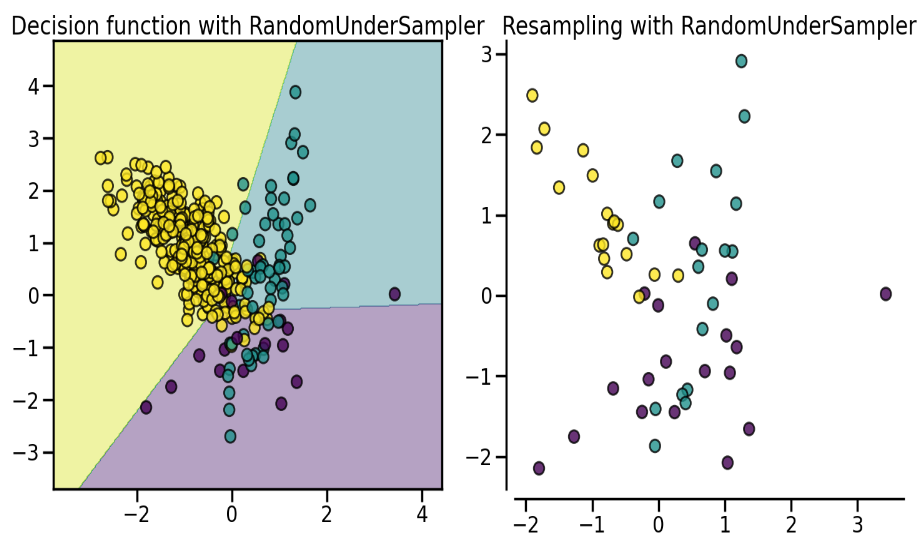

In [37]:
#rus = RandomUnderSampler(random_state=RANDOM_STATE)
#X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

In [38]:
#df_resampled_rus = pd.concat([X_resampled_rus, y_resampled_rus], axis=1)
#df_resampled_rus.to_csv('resampled_rus.csv', index=True)

In [39]:
df_resampled_rus = pd.read_csv("resampled_rus.csv", index_col=0)
X_resampled_rus, y_resampled_rus = df_resampled_rus.drop(columns=['y']), df_resampled_rus['y']

In [40]:
print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_rus).items()))

Zastoupeni trid target promenne po balancingu
[(0, 15186), (1, 15186)]


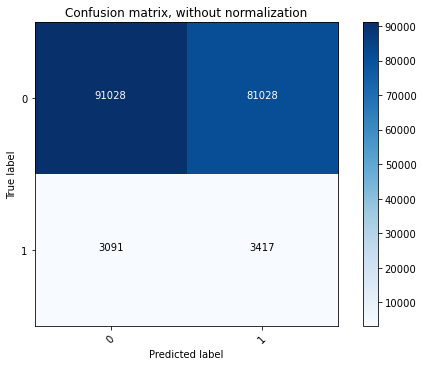

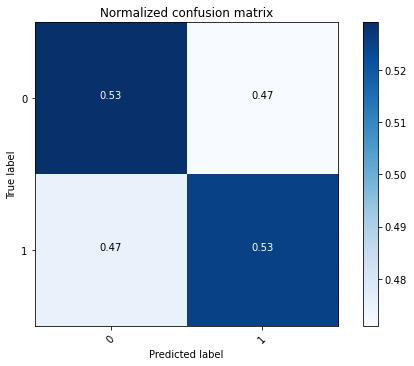

Metoda: rus
accuracy 52.891 %
f1 score 7.514 %


In [41]:
get_results(X_resampled_rus, y_resampled_rus, X_test, y_test, 'rus', DecisionTreeClassifier, results,
                conf_mat=True, print_res=True)

##  OneSidedSelection

Využívá TomekLinks detekci k odstranění šumu v datech, navíc redukuje data z majoritní skupiny pomocí Neighborhood Cleaning Rule (odstraní ta data, která jsou daleko od rozhodovací hranice).

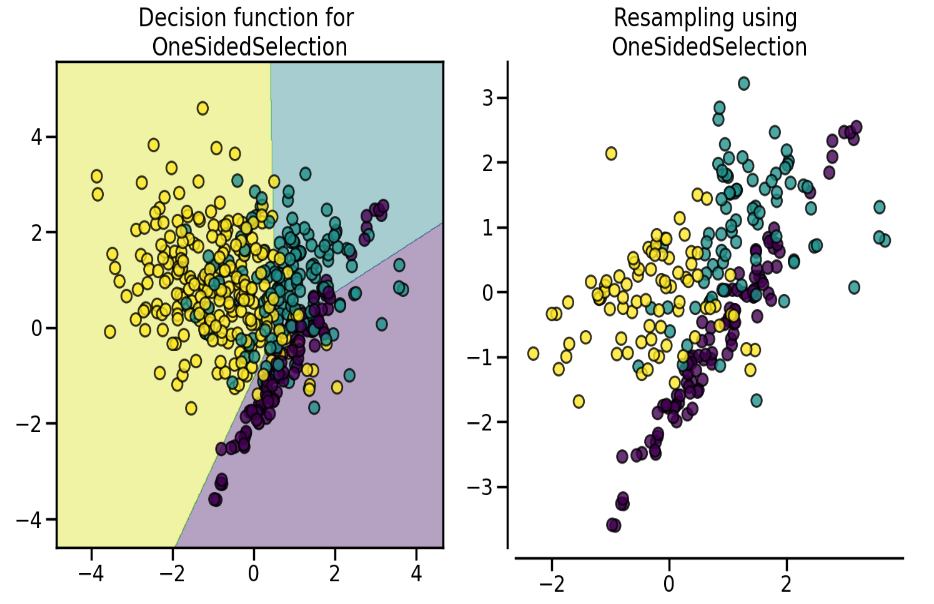

In [42]:
#oss = OneSidedSelection(random_state=0)
#X_resampled_oss, y_resampled_oss = oss.fit_resample(X_train, y_train)

In [43]:
#df_resampled_oss = pd.concat([X_resampled_oss, y_resampled_oss], axis=1)
#df_resampled_oss.to_csv('resampled_oss.csv', index=True)

In [44]:
df_resampled_oss = pd.read_csv("resampled_oss.csv", index_col=0)
X_resampled_oss, y_resampled_oss = df_resampled_oss.drop(columns=['y']), df_resampled_oss['y']

In [45]:
print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_oss).items()))

Zastoupeni trid target promenne po balancingu
[(0, 396855), (1, 15186)]


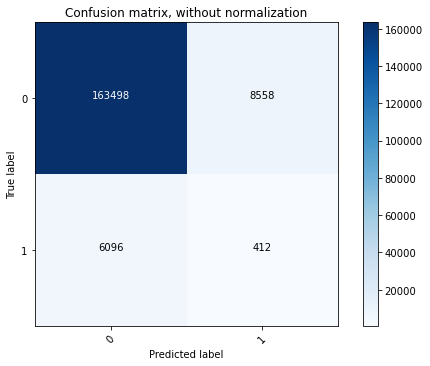

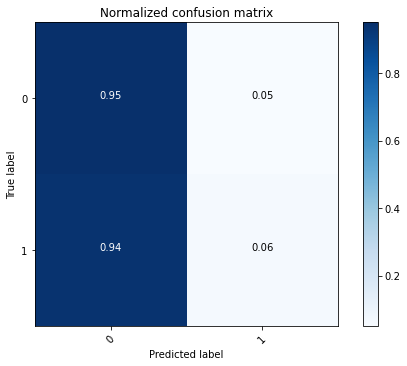

Metoda: oss
accuracy 91.793 %
f1 score 5.324 %


In [46]:
get_results(X_resampled_oss, y_resampled_oss, X_test, y_test, 'oss', DecisionTreeClassifier, results,
                conf_mat=True, print_res=True)

## NeighbourhoodCleaningRule

Provádí redukci dat pomocí čištění dat. Výsledná množina datových bodů, která bude odstraněna vzikne sjednocením výstupů dvou metod. První metoda EditedNearestNeighbours je aplikována na majoritní třídy. Druhá metoda je aplikována na data v minoritní třídě. Pokud pro daný datový bod z minoritní skupinu platí, že tři jeho nejbližší sousedi jsou klasifikování do majoritní třídy, potom je odstraněn nejbližší soused daného datového bodu.
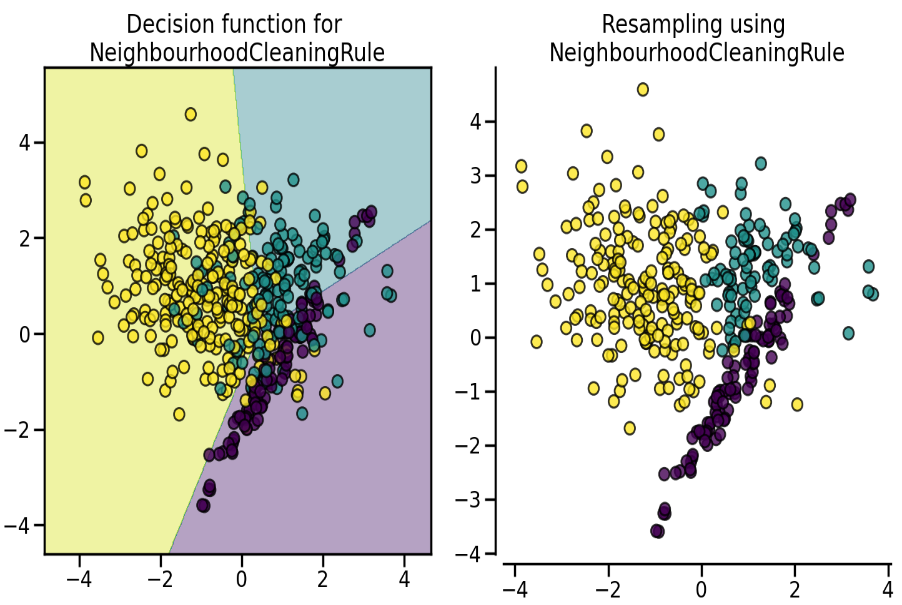


**EditedNearestNeighbours** 
Aplikuje algoritmus nejbližšího souseda a edituje dataset tak, že odstraní taková data, které dostatečně neodpovídají svému okolí. To jak datový bod odpovídá svému okolí je měřeno vybraným selekčním kritériem (mode = musí se shodovat s většinou sousedních bodů, all = musí se shodovat se všemi -- toto kriterium používám).  

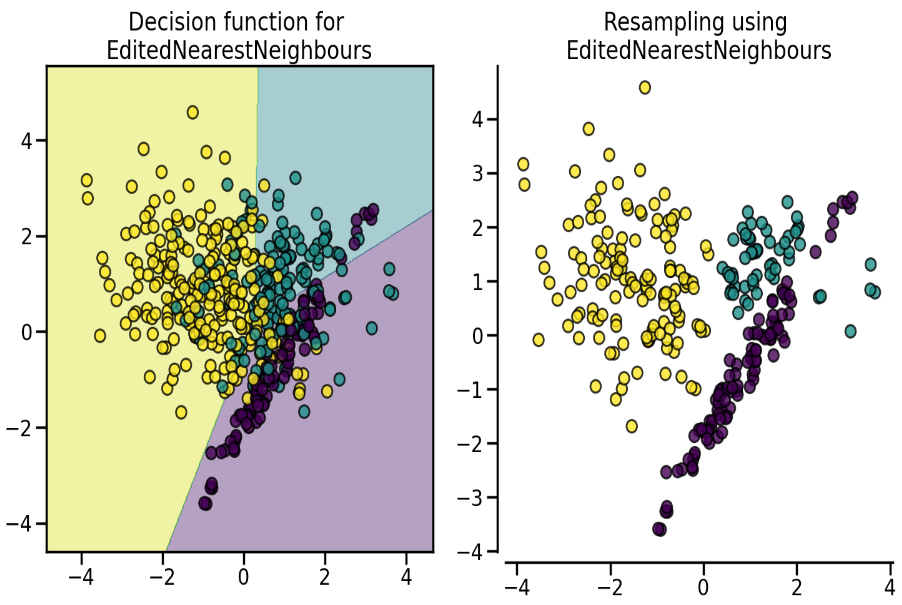


In [47]:
#ncr = NeighbourhoodCleaningRule()
#X_resampled_ncr, y_resampled_ncr = ncr.fit_resample(X_train, y_train)

In [48]:
#df_resampled_ncr = pd.concat([X_resampled_ncr, y_resampled_ncr], axis=1)
#df_resampled_ncr.to_csv('resampled_ncr.csv', index=True)

In [49]:
df_resampled_ncr = pd.read_csv("resampled_ncr.csv", index_col=0)
X_resampled_ncr, y_resampled_ncr = df_resampled_ncr.drop(columns=['y']), df_resampled_ncr['y']

In [50]:
print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_ncr).items()))

Zastoupeni trid target promenne po balancingu
[(0, 360684), (1, 15186)]


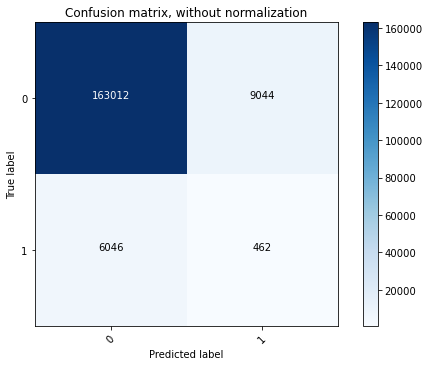

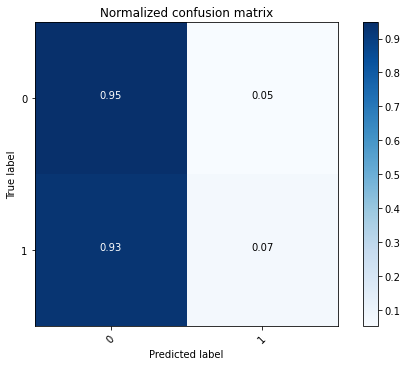

Metoda: ncr
accuracy 91.549 %
f1 score 5.77 %


In [51]:
get_results(X_resampled_ncr, y_resampled_ncr, X_test, y_test, 'ncr', DecisionTreeClassifier, results, 
                conf_mat=True, print_res=True)

# Over-sampling

## RandomOverSampler
Generuje náhodně nová data z minoritní třídy, náhodným výběrem s opakováním z množiny původních dat.

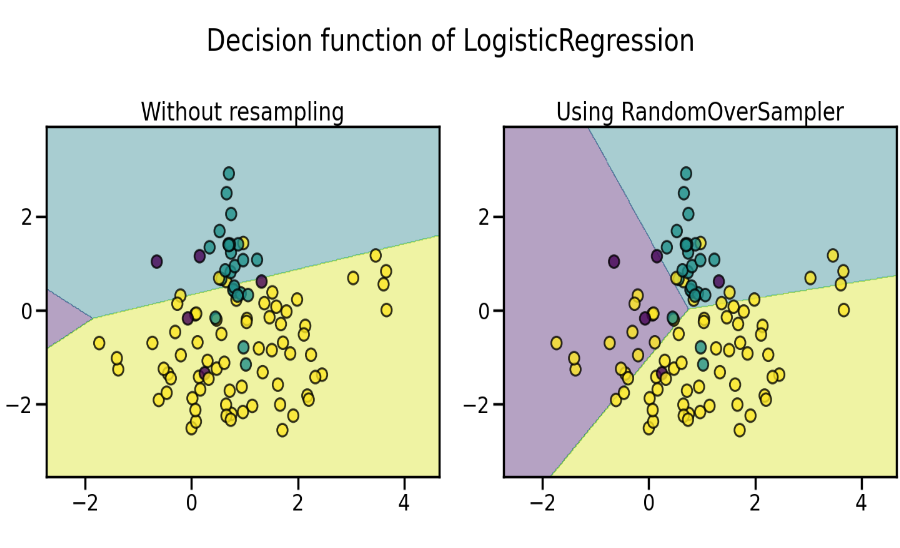

In [52]:
#ros = RandomOverSampler(random_state=RANDOM_STATE)
#X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

In [53]:
#df_resampled_ros = pd.concat([X_resampled_ros, y_resampled_ros], axis=1)
#df_resampled_ros.to_csv('resampled_ros.csv', index=True)

In [54]:
df_resampled_ros = pd.read_csv("resampled_ros.csv", index_col=0)
X_resampled_ros, y_resampled_ros = df_resampled_ros.drop(columns=['y']), df_resampled_ros['y']

In [55]:
print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_ros).items()))

Zastoupeni trid target promenne po balancingu
[(0, 401462), (1, 401462)]


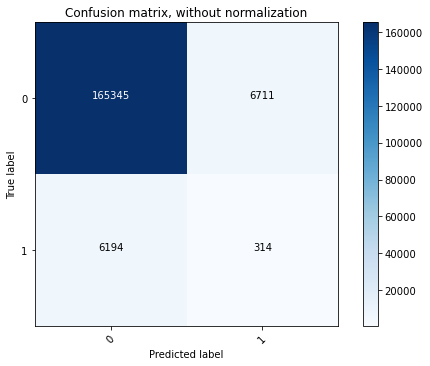

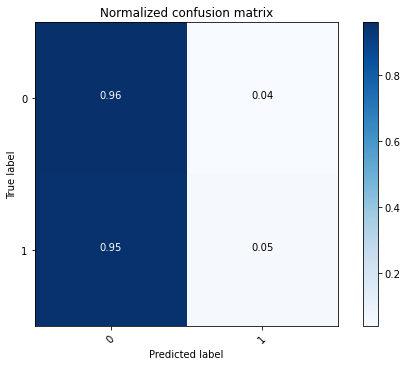

Metoda: ros
accuracy 92.773 %
f1 score 4.641 %


In [56]:
get_results(X_resampled_ros, y_resampled_ros, X_test, y_test, 'ros', DecisionTreeClassifier, results, 
                conf_mat=True, print_res=True)

## SMOTE a ADASYN

= Synthetic Minority Oversampling Technique

= Adaptive Synthetic sampling method

Generují nové data pomocí interpolace. Liší se výběrem dat k interpolaci. Adasyn se více koncentruje na generování dat, které jsou blíže k původním datům, a které jsou navíc špatně klasifikované, zatímco SMOTE (v základní verzi) tak nečiní.

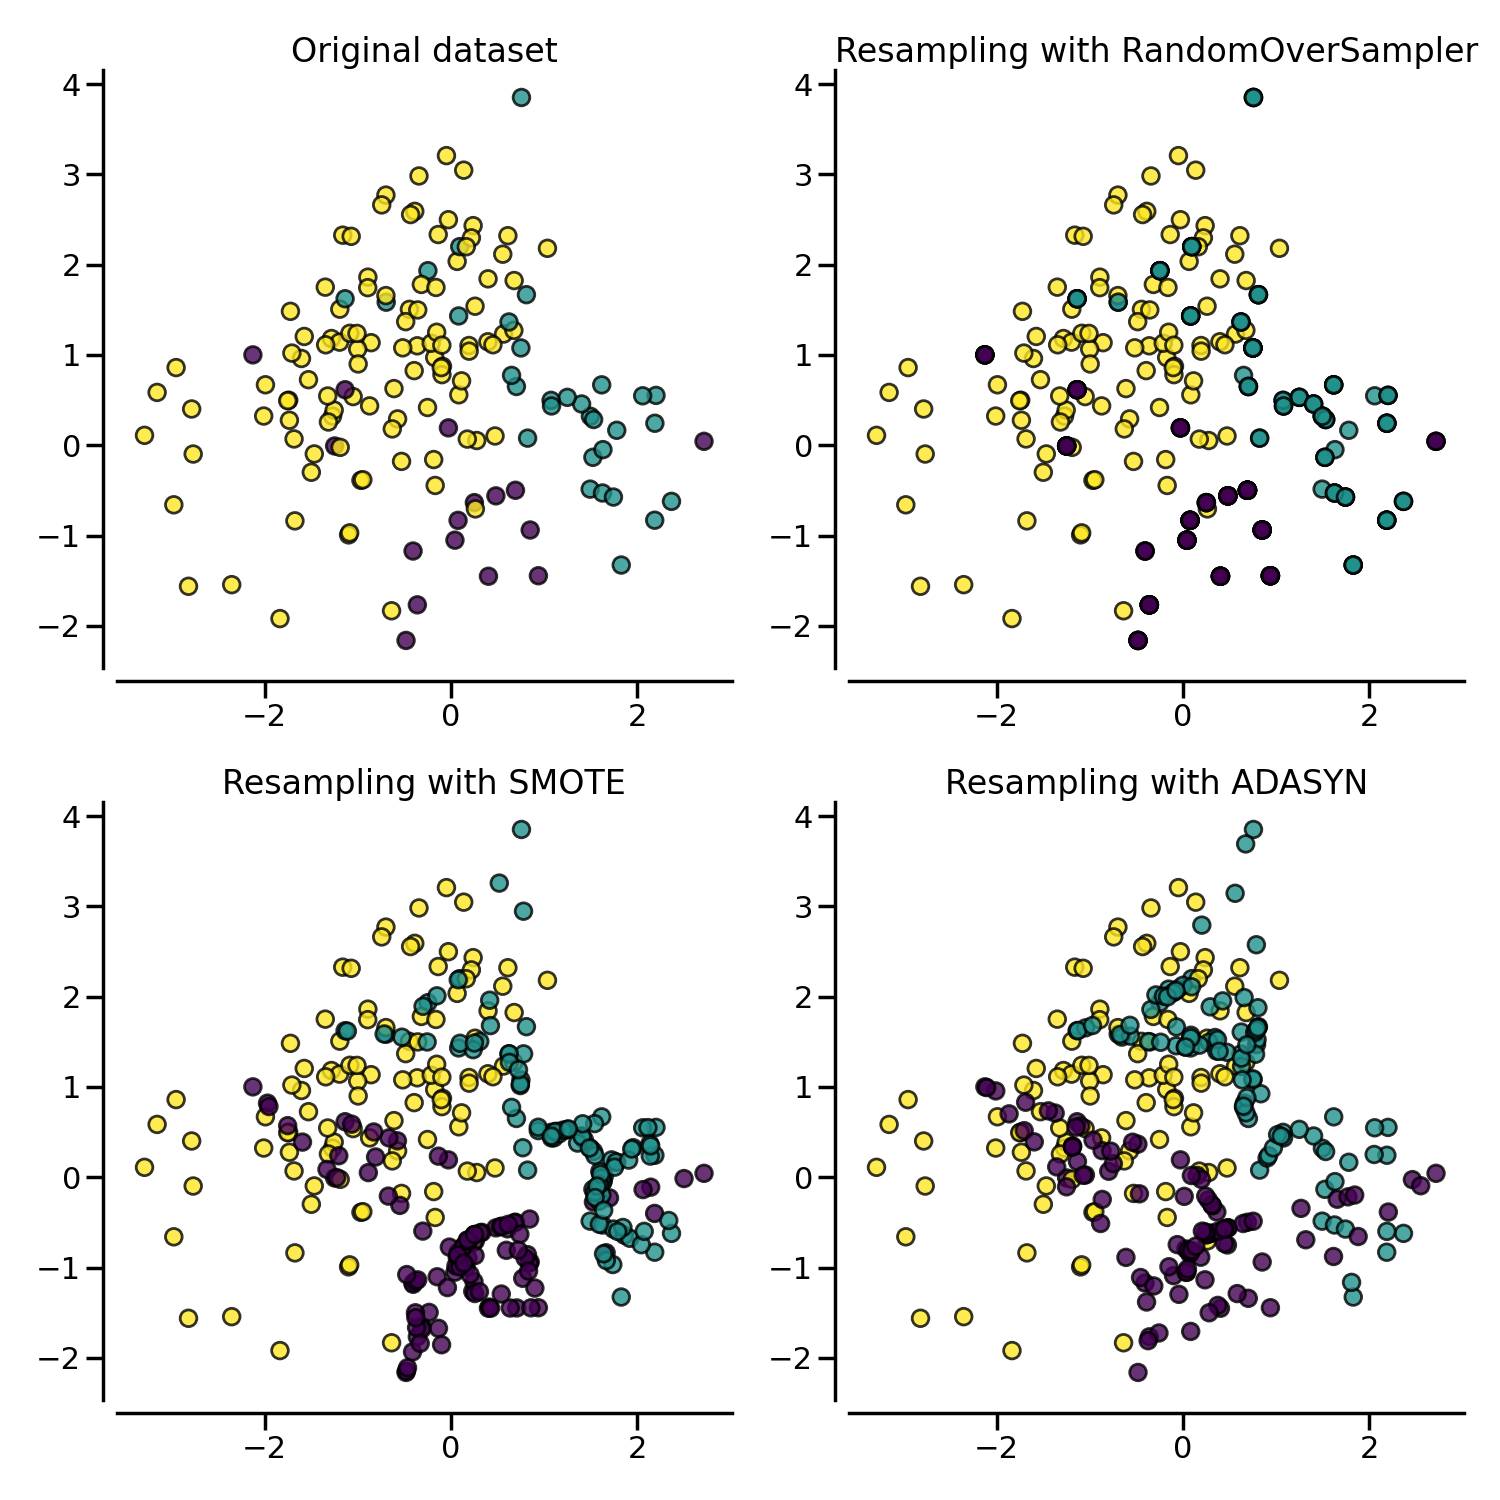

### SMOTE

Prověřovala jsem 3 varianty SMOTE (smote v klasické verzi, BorderlineSMOTE a SVMSMOTE). BorderlineSMOTE a SVMSMOTE se zaměřují na datové body, které leží poblíž hranice optimální rozhodovací funkce a generují data v opačném směru než leží nejbližší sousední data naležící jiné třídě. Na základě výsledků F1 skóre na validační sadě dat, jsem vybrala nejlepší variantu SMOTE.

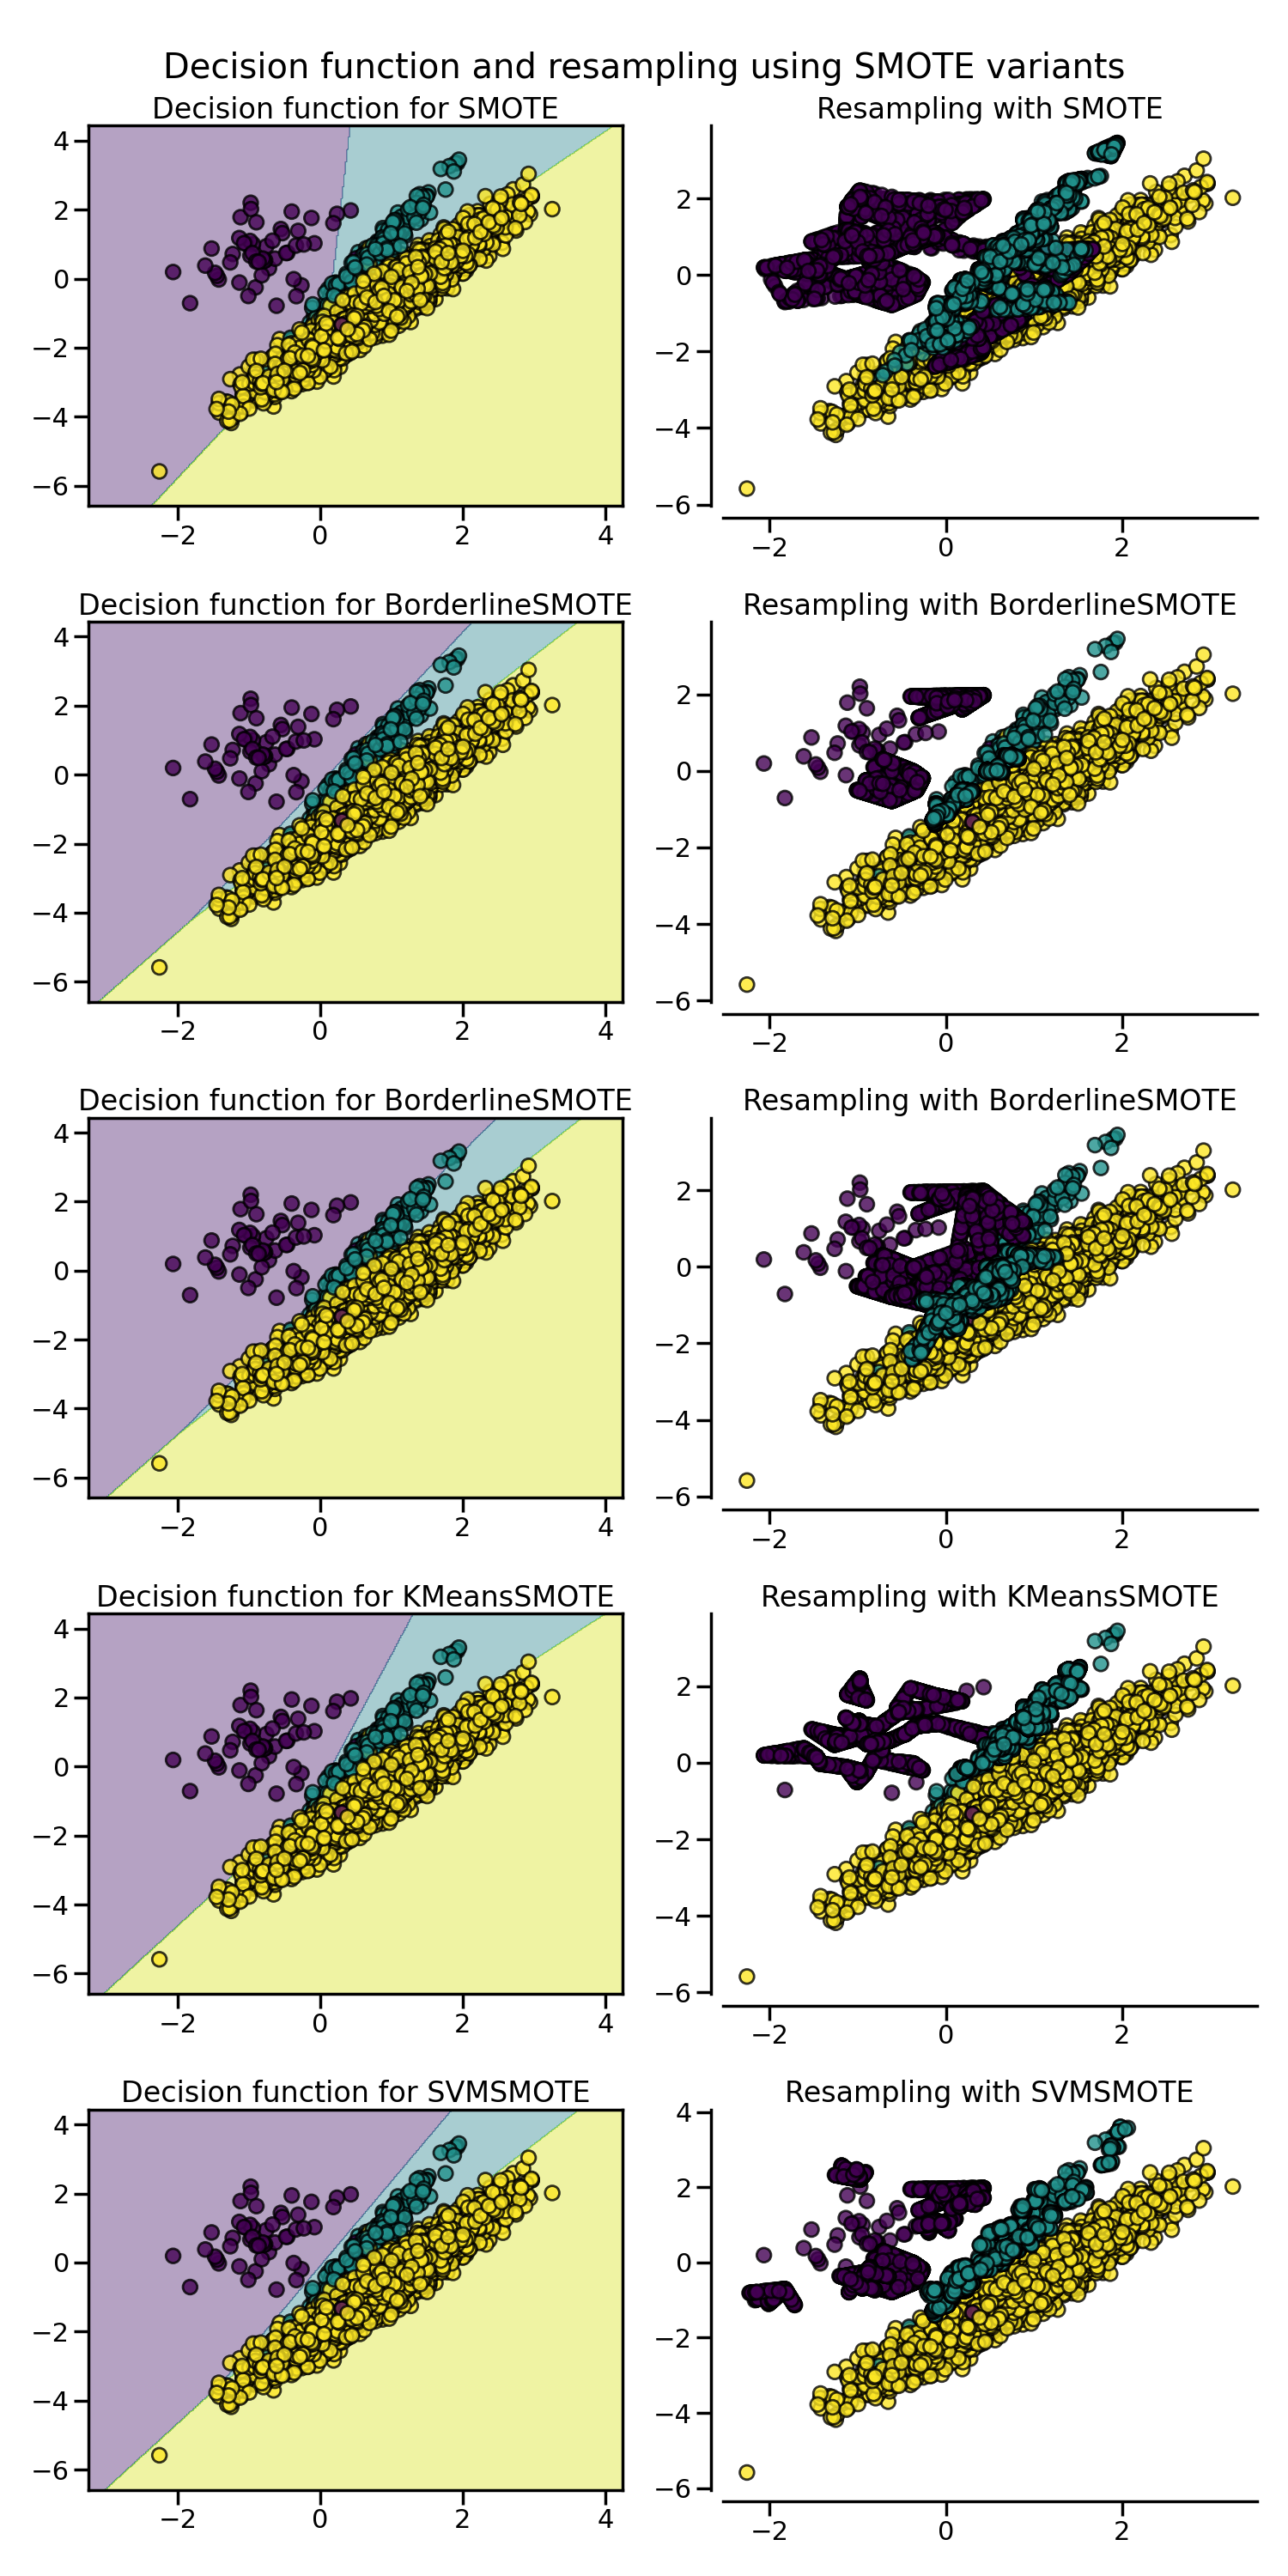

In [57]:
smote_results = pd.DataFrame(columns=['method', 'acc', 'f1'])

### SMOTE v základní verzi

In [58]:
#X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train, y_train)

#df_resampled_smote = pd.concat([X_resampled_smote, y_resampled_smote], axis=1)
#df_resampled_smote.to_csv('resampled_smote.csv', index=True)

df_resampled_smote = pd.read_csv("resampled_smote.csv", index_col=0)
X_resampled_smote, y_resampled_smote = df_resampled_smote.drop(columns=['y']), df_resampled_smote['y']

print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_smote).items()))

Zastoupeni trid target promenne po balancingu
[(0, 301096), (1, 301096)]


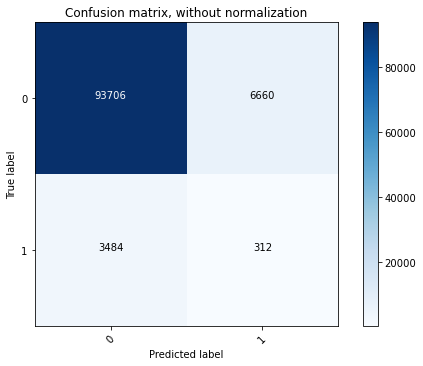

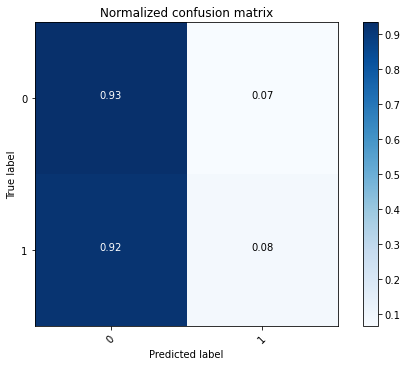

Metoda: smote
accuracy 90.261 %
f1 score 5.795 %


In [59]:
get_results(X_resampled_smote, y_resampled_smote, X_val, y_val, 'smote', DecisionTreeClassifier, smote_results, 
                conf_mat=True, print_res=True)

### BorderlineSMOTE

In [60]:
#X_resampled_BorderlineSMOTE, y_resampled_BorderlineSMOTE = BorderlineSMOTE().fit_resample(X_train, y_train)

#df_resampled_BorderlineSMOTE = pd.concat([X_resampled_BorderlineSMOTE, y_resampled_BorderlineSMOTE], axis=1)
#df_resampled_BorderlineSMOTE.to_csv('resampled_BorderlineSMOTE.csv', index=True)

df_resampled_BorderlineSMOTE = pd.read_csv("resampled_BorderlineSMOTE.csv", index_col=0)
X_resampled_BorderlineSMOTE, y_resampled_BorderlineSMOTE = df_resampled_BorderlineSMOTE.drop(columns=['y']), df_resampled_BorderlineSMOTE['y']

print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_BorderlineSMOTE).items()))

Zastoupeni trid target promenne po balancingu
[(0, 301096), (1, 301096)]


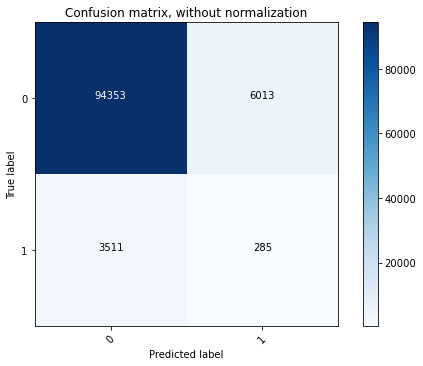

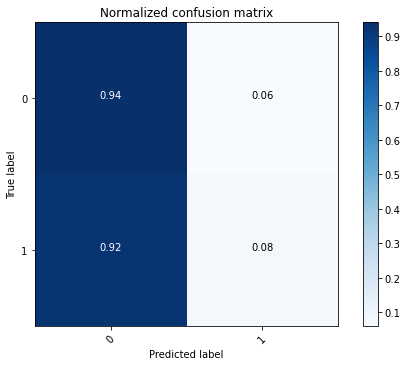

Metoda: BorderlineSMOTE
accuracy 90.857 %
f1 score 5.647 %


In [61]:
get_results(X_resampled_BorderlineSMOTE, y_resampled_BorderlineSMOTE, X_val, y_val, 'BorderlineSMOTE', DecisionTreeClassifier, smote_results, 
                conf_mat=True, print_res=True)

### SVMSMOTE

In [62]:
#X_resampled_SVMSMOTE, y_resampled_SVMSMOTE = SVMSMOTE().fit_resample(X_train, y_train)

#df_resampled_SVMSMOTE = pd.concat([X_resampled_SVMSMOTE, y_resampled_SVMSMOTE], axis=1)
#df_resampled_SVMSMOTE.to_csv('resampled_SVMSMOTE.csv', index=True)

df_resampled_SVMSMOTE = pd.read_csv("resampled_SVMSMOTE.csv", index_col=0)
X_resampled_SVMSMOTE, y_resampled_SVMSMOTE = df_resampled_SVMSMOTE.drop(columns=['y']), df_resampled_SVMSMOTE['y']

print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_SVMSMOTE).items()))

Zastoupeni trid target promenne po balancingu
[(0, 301096), (1, 173201)]


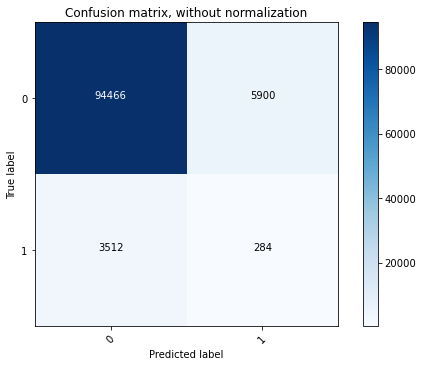

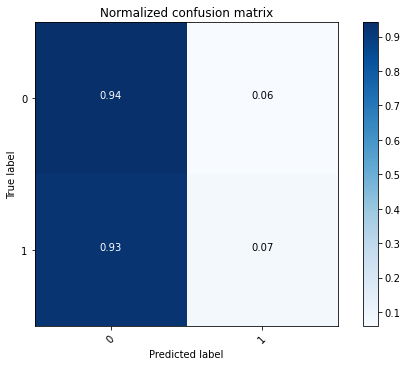

Metoda: SVMSMOTE
accuracy 90.964 %
f1 score 5.691 %


In [63]:
get_results(X_resampled_SVMSMOTE, y_resampled_SVMSMOTE, X_val, y_val, 'SVMSMOTE', DecisionTreeClassifier, smote_results, 
                conf_mat=True, print_res=True)

### Výsledky
Nejlepších výsledků, měřených pomocí F1 skóre, na validační sadě dat dosahovala metoda SMOTE v základní verzi. Nyní ji tedy otestuji na testovací sadě dat.

In [64]:
smote_results

method     acc     f1
0            smote  90.261  5.795
1  BorderlineSMOTE  90.857  5.647
2         SVMSMOTE  90.964  5.691

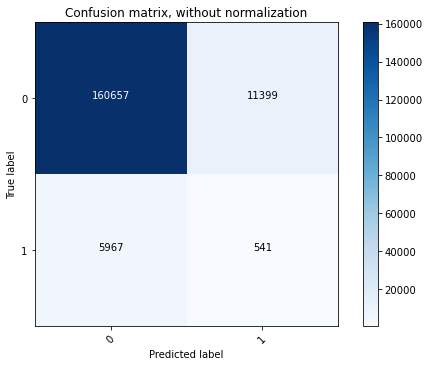

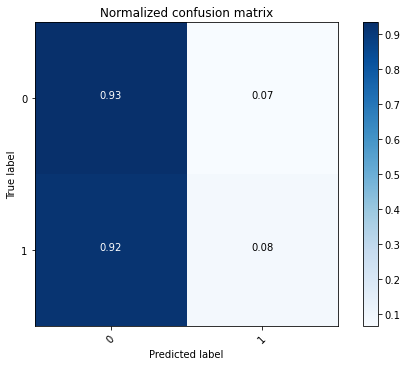

Metoda: smote
accuracy 90.275 %
f1 score 5.865 %


In [65]:
# vysledku smote na testovaci sade dat
get_results(X_resampled_smote, y_resampled_smote, X_test, y_test, 'smote', DecisionTreeClassifier, results, 
                conf_mat=True, print_res=True)

### ADASYN

In [66]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)

In [67]:
df_resampled_adasyn = pd.concat([X_resampled_adasyn, y_resampled_adasyn], axis=1)
df_resampled_adasyn.to_csv('resampled_adasyn.csv', index=True)

In [68]:
#df_resampled_adasyn = pd.read_csv("resampled_adasyn.csv", index_col=0)
#X_resampled_adasyn, y_resampled_adasyn = df_resampled_adasyn.drop(columns=['y']), df_resampled_adasyn['y']

print('Zastoupeni trid target promenne po balancingu')
print(sorted(Counter(y_resampled_adasyn).items()))

Zastoupeni trid target promenne po balancingu
[(0, 301096), (1, 296279)]


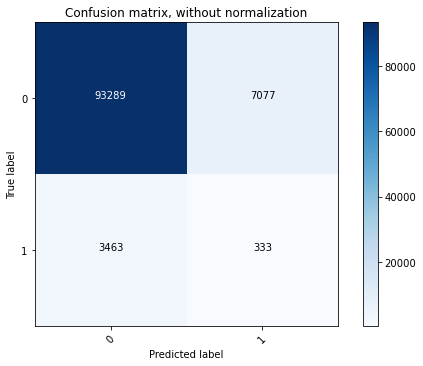

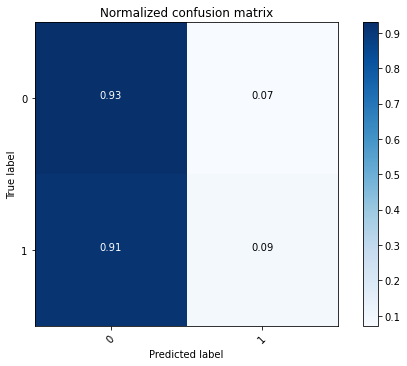

Metoda: adasyn
accuracy 89.881 %
f1 score 5.943 %


In [69]:
get_results(X_resampled_adasyn, y_resampled_adasyn, X_val, y_val, 'adasyn', DecisionTreeClassifier, results, 
                conf_mat=True, print_res=True)

## Srovnání data balancing metod na testovací sadě
Výsledky F1 skóre modelů na testovací sadě dat ukazují, že nejlepších výsledků bylo dosaženo balancing metodou Random Under Sampler, jak je vidět z tabulky a grafu níže. Nejhůře dopadla naopak metoda Random Over Sampler. Ani jedna z metod však nepřinesla zásadní vylepšní F1 skóre.

In [70]:
# pomocna fukce pro sestrojeni grafu nad vysledky

def make_graph_balancing(results_df, metrics):
    WIDTH, HEIGHT = 20, 12
    FONT_SIZE = 20
    plt.figure(figsize=(WIDTH, HEIGHT))
    X_axis = np.arange(len(results_df))
    bar_w = 0.25
    
    bar1 = plt.bar(X_axis, results_df[metrics], bar_w, color='b')
    
    plt.xticks(X_axis, results_df['method'], fontsize=FONT_SIZE)
    plt.xlabel('metoda', fontsize=FONT_SIZE)
    plt.ylabel(f'{metrics} skore v %', fontsize=FONT_SIZE)
    plt.title(f'Srovnani vysledku - metrika {metrics} skore', fontsize=FONT_SIZE+2)
    
    for rect in bar1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                str(height),
                ha='center', va='bottom', fontsize=FONT_SIZE)
    
    plt.show()

Tabulka s výsledky:

- origin = data bez vyvažování 
- rus = Random Under Sampler
- oss = One Sided Selection
- ncr = Neighbourhood Cleaning Rule
- ros = Random Over Sampler
- smote = Synthetic Minority Oversampling Technique
- adasyn = Adaptive Synthetic sampling method

In [71]:
# vysledky jednotlivych modelu 
results

method     acc     f1
0  origin  91.872  5.385
1     rus  52.891  7.514
2     oss  91.793  5.324
3     ncr  91.549  5.770
4     ros  92.773  4.641
5   smote  90.275  5.865
6  adasyn  89.881  5.943

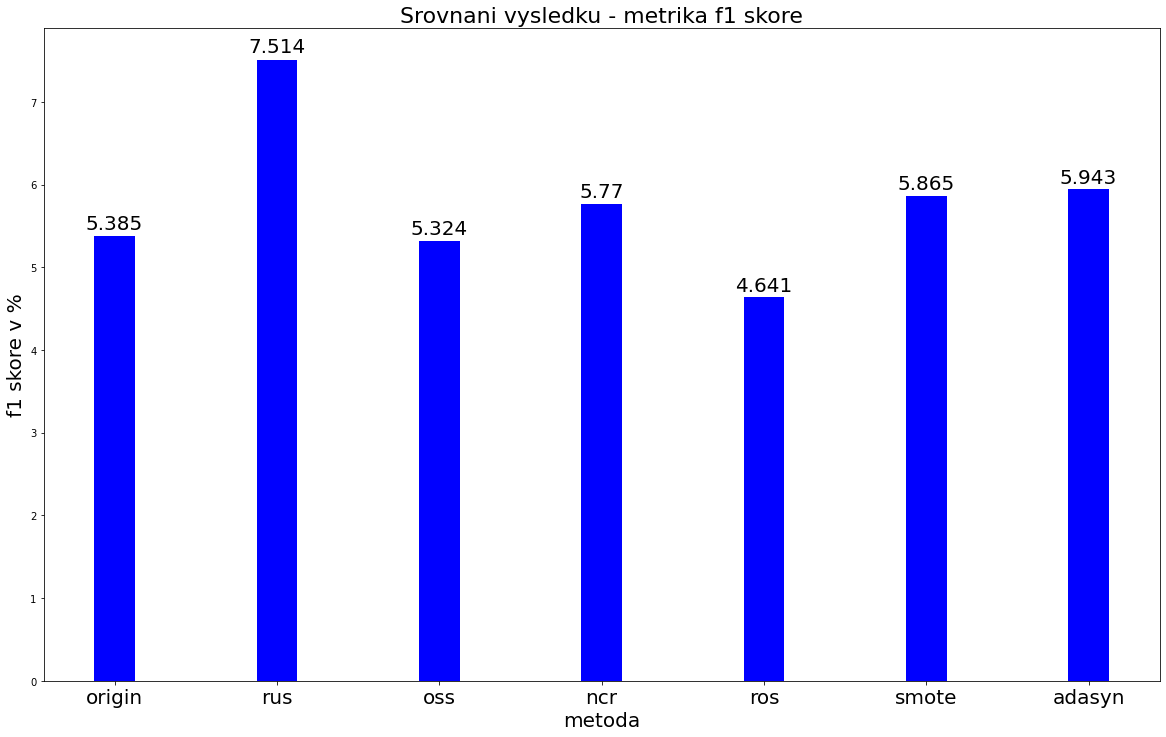

In [72]:
# f1 skore pro jednotlive modely
make_graph_balancing(results, 'f1')

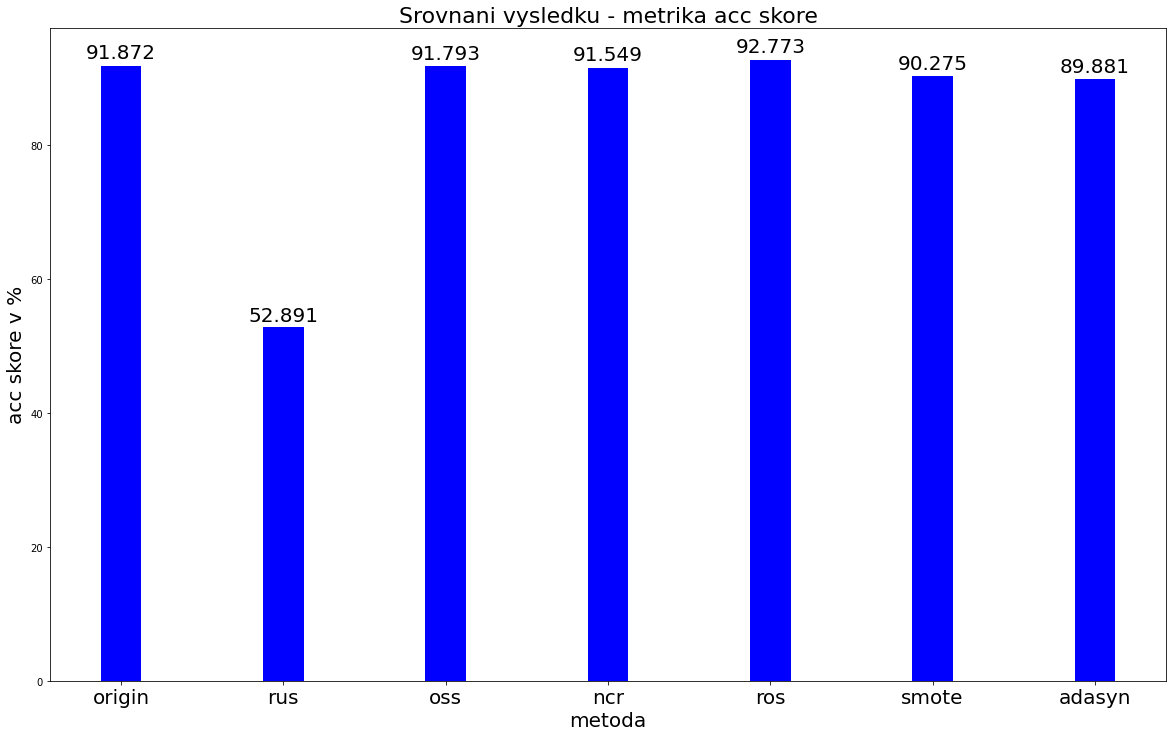

In [73]:
# accuracy pro jednotlive modely
make_graph_balancing(results, 'acc')